In [1]:
import sys
sys.path.append('..')

In [2]:
from apache_beam_examples import read_write_tfrecord

In [3]:
read_write_tfrecord.write_tfrecords()

[I 190427 06:57:04 read_write_tfrecord:224] data already present, no need to download
[I 190427 06:57:04 read_write_tfrecord:49] Extracting: /tmp/data/mnist/val/images.gz
[I 190427 06:57:04 read_write_tfrecord:79] Extracting: /tmp/data/mnist/val/labels.gz
[I 190427 06:57:04 read_write_tfrecord:104] images shape: (10000, 28, 28, 1)
[I 190427 06:57:04 read_write_tfrecord:105] labels shape: (10000,)


0
1
1
1
1
0
1
1
1
0


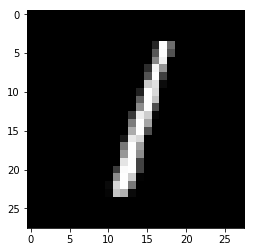

In [5]:
img = read_write_tfrecord.read_tfrecord('eval-mnist-00000-of-00001.gz', idx=2)
read_write_tfrecord.display_image(img)

In [3]:
read_write_tfrecord.write_tfrecords()

[I 190427 06:51:59 read_write_tfrecord:201] data already present, no need to download
[I 190427 06:51:59 read_write_tfrecord:47] Extracting: /tmp/data/mnist/val/images.gz
[I 190427 06:51:59 read_write_tfrecord:77] Extracting: /tmp/data/mnist/val/labels.gz
[I 190427 06:51:59 read_write_tfrecord:102] images shape: (10000, 28, 28, 1)
[I 190427 06:51:59 read_write_tfrecord:103] labels shape: (10000,)


In [4]:
# check that the output file has more than 1 record!

In [5]:
from apache_beam_examples.read_write_tfrecord import *

In [6]:
from apache_beam_examples.read_write_tfrecord import _parse_function

In [7]:
TFRECORD_OUTFILE = 'mnist'

tfrecord_infile = '{}-00000-of-00001.gz'.format(TFRECORD_OUTFILE)

raw_dataset = get_raw_dataset(tfrecord_infile)

parsed_dataset = raw_dataset.map(_parse_function)

In [8]:
iterator = parsed_dataset.make_one_shot_iterator()

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


In [9]:
count = 0
for i, x in enumerate(parsed_dataset.take(10)):
    if i == 3:
        parsed_record = x
        break
    
count

0

In [10]:
img = convert_parsed_record_to_ndarray(parsed_record)
img.shape

(28, 28, 1)

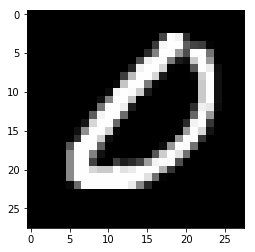

In [11]:
display_image(img)

# partition_fn

In [12]:
import apache_beam as beam
import hashlib
import bisect

SLICE = slice(0,10)
SPLITS = ['train', 'eval']

def _partition_fn(
        record,
        num_partitions,  # pylint: disable=unused-argument
        buckets):
    bucket = int(hashlib.sha256(record).hexdigest(), 16) % buckets[-1]
    # For example, if buckets is [10,50,80], there will be 3 splits:
    #   bucket >=0 && < 10, returns 0
    #   bucket >=10 && < 50, returns 1
    #   bucket >=50 && < 80, returns 2
    int_split = bisect.bisect(buckets, bucket)
    print(int_split)
    return int_split

@beam.ptransform_fn
@beam.typehints.with_input_types(beam.Pipeline)
@beam.typehints.with_output_types(tf.train.Example)
def _ImageToExample(pipeline, input_dict):
    data_dir = input_dict['input-base']

    images_path = os.path.join(data_dir, 'images.gz')
    labels_path = os.path.join(data_dir, 'labels.gz')

    images, labels = get_images_and_labels(images_path, labels_path)

    images_w_index, labels_w_index = get_images_and_labels_w_index(
        images, labels)

    # Beam Pipeline
    image_line = pipeline | "CreateImage" >> beam.Create(images_w_index[SLICE])
    label_line = pipeline | "CreateLabel" >> beam.Create(labels_w_index[SLICE])
    group_by = ({
        'label': label_line,
        'image': image_line
    }) | beam.CoGroupByKey()
    return (group_by | "GroupByToTfExample" >> beam.Map(group_by_tf_example))


def write_tfrecords():
    """
    Main write function
    """
    maybe_download()
    input_dict = {'input-base': '/tmp/data/mnist/val/'}
    buckets = [50, 100]
    with beam.Pipeline(options=PipelineOptions()) as p:
        tf_example = p | "InputSourceToExample" >> _ImageToExample(input_dict)

        serialize = (
            tf_example | 'SerializeDeterministically' >>
            beam.Map(lambda x: x.SerializeToString(deterministic=True)))
        
        example_splits = serialize | 'SplitData' >> beam.Partition(_partition_fn, len(buckets), buckets)

        for i, example_split in enumerate(example_splits):
            split_name = SPLITS[i]
            (example_split | "Write."+split_name >>
             beam.io.WriteToTFRecord(split_name+'-'+TFRECORD_OUTFILE, file_name_suffix='.gz'))
        
write_tfrecords()

[I 190427 06:52:26 read_write_tfrecord:201] data already present, no need to download
[I 190427 06:52:26 read_write_tfrecord:47] Extracting: /tmp/data/mnist/val/images.gz
[I 190427 06:52:26 read_write_tfrecord:77] Extracting: /tmp/data/mnist/val/labels.gz
[I 190427 06:52:26 read_write_tfrecord:102] images shape: (10000, 28, 28, 1)
[I 190427 06:52:26 read_write_tfrecord:103] labels shape: (10000,)


0
1
1
1
1
0
1
1
1
0


In [13]:
!ls

MNIST-all-data-and-partition-fn.ipynb
MNIST-gzip-input-to-tf-example.ipynb
beam-temp-evalmnist-2d1372b0682b11e985087831c1ce2448
beam-temp-evalmnist-911f7d3a682911e9b6357831c1ce2448
beam-temp-trainmnist-2d0c2a59682b11e9b3f37831c1ce2448
beam-temp-trainmnist-91214535682911e99fe47831c1ce2448
composite-transform.ipynb
eval-mnist-00000-of-00001.gz
global-pipeline.ipynb
group-by-key-input.csv
mnist-00000-of-00001.gz
output-2.txt-00000-of-00001
output-3.txt-00000-of-00001
output-4.txt-00000-of-00001
output-5.txt-00000-of-00001
output-6.txt-00000-of-00001
output-7.txt-00000-of-00001
output-8.txt-00000-of-00001
output-9-partition-0.txt-00000-of-00001
output-9-partition-1.txt-00000-of-00001
output.txt-00000-of-00001
overview.ipynb
read-image-tfrecord.ipynb
read-in-data-and-write-tfrecord-with-beam.ipynb
train-mnist-00000-of-00001.gz
trainmnist-00000-of-00001.gz


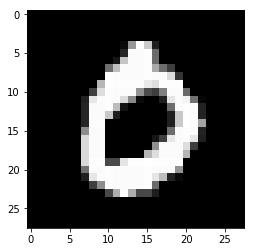

In [14]:
img = read_tfrecord('eval-mnist-00000-of-00001.gz', idx=1)
display_image(img)

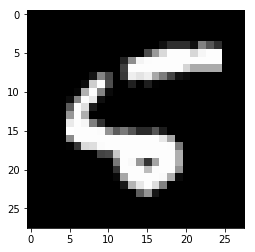

In [15]:
img = read_tfrecord('train-mnist-00000-of-00001.gz', idx=2)
display_image(img)

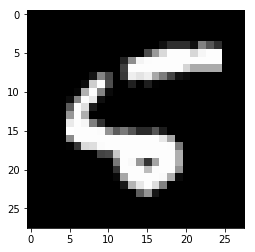

In [16]:
display_image(img)